# **Loading data and packages**

**Libraries import**

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from joblib import load, dump

from sklearn.model_selection import (
    train_test_split, LeaveOneOut, cross_validate, learning_curve, cross_val_predict
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    make_scorer, confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.ensemble import (
    ExtraTreesClassifier, RandomForestClassifier,
    AdaBoostClassifier, GradientBoostingClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import geometric_mean_score

import os
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from imblearn.over_sampling import SMOTENC

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.metrics import geometric_mean_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from imblearn.under_sampling import RandomUnderSampler, TomekLinks





**Data import**

In [2]:
# Defining global variables to store the DataFrame
df = pd.DataFrame()
dataset_name = None  

# Function to load and process the selected dataset
def load_and_process_data(selected_data):
    global df, dataset_name  
    dataset_name = selected_data  
    
    if selected_data == 'Clinical data':
        df = pd.read_table(clinic_dataset, sep=',')
        df['Gênero'] = df['Gênero'].replace('M', 0)
        df['Gênero'] = df['Gênero'].replace('F', 1)
        columns_to_drop = ['Espasticidade', 'Neuropatia MMSS', 'Bexiga Neurogênica', 'Código', 'Prontuário']
        df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

    elif selected_data == 'Clinic dataset cat 1':
        df = pd.read_table(clinic_dataset_cat1, sep=',')
        df['Gênero'] = df['Gênero'].replace('M', 0)
        df['Gênero'] = df['Gênero'].replace('F', 1)
        columns_to_drop = ['Código', 'Prontuário']
        df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1)

    elif selected_data == 'Hemogram data':
        df = pd.read_table(hemogram_dataset, sep=',')
        df.rename(columns={'Provável HAM/TSP':'PROVAVEL_HAM/TSP' }, inplace=True)
        df['Gênero'] = df['Gênero'].replace('M', 0)
        df['Gênero'] = df['Gênero'].replace('F', 1)
        columns_to_drop = ['Blastos', 'Promielocitos', 'Mielocitos', 'Metamielocitos', 'Bastonetes', 
                         'Linfocitos Atipicos', 'Eritroblastos', 'HAM/TSP', 'Código']
        df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)
        df.rename(columns={'Ano_hemograma':'Idade_clinica'}, inplace=True)
        for col in df.select_dtypes(include=['object']).columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        # Normalization with MinMaxScaler, except for the specified columns
        cols_to_normalize = df.columns.difference(['PROVAVEL_HAM/TSP', 'Gênero', 'rs10748643', 'rs11188513'])
        scaler = MinMaxScaler()
        df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])
        print(f"Data Loaded and Processed Successfully! Dataset: {dataset_name}")

    elif selected_data == 'Hemogram data cat 1':
        df = pd.read_table(hemogram_dataset_cat1, sep=',')

        # Normalization with MinMaxScaler, except for the specified columns
        for col in df.select_dtypes(include=['object']).columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
       
        print(f"Data Loaded and Processed Successfully! Dataset: {dataset_name}")
    else:
        df = pd.DataFrame()

    return df.head()

# List of dataset options
data_options = ['Clinical data', 'Hemogram data', 'Clinic dataset cat 1', 'Hemogram data cat 1']

# Selection widget to choose the dataset
data_selector = widgets.Dropdown(
    options=data_options,
    description='Select Data:'
)

# Interactive function to load and process the selected dataset
@interact(selected_data=data_selector)
def load_and_process_selected_data(selected_data):
    return load_and_process_data(selected_data)


interactive(children=(Dropdown(description='Select File:', options=('df_Hemogram_data_cat_1_RUS.csv', 'df_Hemo…

interactive(children=(Dropdown(description='Balancing Method:', options=('Random Over Sampler', 'SMOTENC', 'Ra…

#  **Definition of variables, models and metrics**

**Define the variables (X and y) and classifiers** 

In [3]:
# List of model names that have been adjusted
model_names = ['DT', 'GB', 'LR', 'MLP', 'NB', 'RF', 'SVM', 'KNN', 'AB', 'LSVM']

# Directory where models and results are saved
model_dir = '..\\models\\'

# Dictionary to store loaded templates
classifiers = {}

# Function for loading templates
def load_model(model_name):
    model_path = os.path.join(model_dir, f'best_{model_name}_model.joblib')

    if os.path.exists(model_path):
        # Load the model
        model = load(model_path)

        
        if isinstance(model, SVC):
            model.probability = True

        # Add the model to the classifiers dictionary using the corresponding name
        classifiers[model_name] = model

        print(f'Modelo {model_name} carregado com sucesso.')
    else:
        print(f'Arquivo para o modelo {model_name} não encontrado.')

# Iterate over all the model names and load them
for model_name in model_names:
    load_model(model_name)

Modelo DT carregado com sucesso.
Modelo GB carregado com sucesso.
Modelo LR carregado com sucesso.
Modelo MLP carregado com sucesso.
Modelo NB carregado com sucesso.
Modelo RF carregado com sucesso.
Modelo SVM carregado com sucesso.
Modelo KNN carregado com sucesso.
Modelo AB carregado com sucesso.
Modelo LSVM carregado com sucesso.


In [4]:
print(balancing_method_selected)

Random Under Sampler


# **Model evaluation**

Generation of the results

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.metrics import geometric_mean_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

# Lista para armazenar os resultados
results = []

# Definir a estratégia Leave-One-Out
loo = LeaveOneOut()

# Função para aplicar o método de balanceamento selecionado
def get_balancing_method():
    global balancing_method_selected
    if balancing_method_selected == 'Random Over Sampler':
        return RandomOverSampler(random_state=42)
    elif balancing_method_selected == 'SMOTENC':
        categorical_columns = [col for col in X.columns if col != 'Idade_clinica']  # Ajuste conforme seu dataset
        categorical_features = [X.columns.get_loc(col) for col in categorical_columns]
        return SMOTENC(categorical_features=categorical_features, random_state=42)
    elif balancing_method_selected == 'Random Under Sampler':
        return RandomUnderSampler(random_state=42)
    elif balancing_method_selected == 'Tomek Links':
        return TomekLinks()
    else:
        print("Nenhum método de balanceamento válido selecionado.")
        return None

# Iterando sobre os classificadores
for clf_name, clf in classifiers.items():
    
    # Obtendo o método de balanceamento selecionado
    balancing_method = get_balancing_method()
    
    if balancing_method is None:
        print(f"Erro: Nenhum método de balanceamento válido para o classificador {clf_name}. Pulando este classificador.")
        continue

    # Definir o pipeline usando o Pipeline do imblearn
    pipeline = Pipeline([
        ('balancing', balancing_method),
        ('classifier', clf)
    ])
    
    # Previsões com Leave-One-Out para rótulos
    y_pred = cross_val_predict(pipeline, X, y, cv=loo)

    # Previsões com Leave-One-Out para probabilidades (se aplicável)
    try:
        y_prob = cross_val_predict(pipeline, X, y, cv=loo, method='predict_proba')[:, 1]
    except AttributeError:
        if hasattr(clf, "decision_function"):
            y_prob = cross_val_predict(pipeline, X, y, cv=loo, method='decision_function')
            # Normalizando para o intervalo [0, 1]
            y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())
        else:
            y_prob = np.zeros_like(y_pred)  # Caso o classificador não tenha `predict_proba` ou `decision_function`

    # Calcular as métricas
    test_scores = {
        'classifier': clf_name,
        'Accuracy': accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred, zero_division=0),
        'Recall': recall_score(y, y_pred, zero_division=0),
        'F1': f1_score(y, y_pred, zero_division=0),
        'ROC AUC': roc_auc_score(y, y_prob) if len(np.unique(y)) > 1 else np.nan,
        'G-Mean': geometric_mean_score(y, y_pred)
    }

    # Adicionar os resultados à lista
    results.append(test_scores)

# Converter os resultados para DataFrame
results_df = pd.DataFrame(results)

# Exibir os resultados
print(results_df)


c:\Users\lmbbu\anaconda3\envs\ML-2024python3_11__20241004\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lmbbu\anaconda3\envs\ML-2024python3_11__20241004\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=832).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\lmbbu\anaconda3\envs\ML-2024python3_11__20241004\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=832).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\lmbbu\anaconda3\envs\ML-2024python3_11__20241004\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_it

  classifier  Accuracy  Precision    Recall        F1   ROC AUC    G-Mean
0         DT  0.696629   0.450000  0.782609  0.571429  0.669302  0.722315
1         GB  0.617978   0.403509  1.000000  0.575000  0.484848  0.696311
2         LR  0.617978   0.310345  0.391304  0.346154  0.594203  0.522233
3        MLP  0.741573   0.000000  0.000000  0.000000  0.624506  0.000000
4         NB  0.483146   0.255319  0.521739  0.342857  0.478261  0.495035
5         RF  0.516854   0.282609  0.565217  0.376812  0.509881  0.531610
6        SVM  0.595506   0.355556  0.695652  0.470588  0.548748  0.624489
7        KNN  0.595506   0.348837  0.652174  0.454545  0.625823  0.612776
8         AB  0.595506   0.348837  0.652174  0.454545  0.567852  0.612776
9       LSVM  0.617978   0.310345  0.391304  0.346154  0.588933  0.522233


Heatmap plot

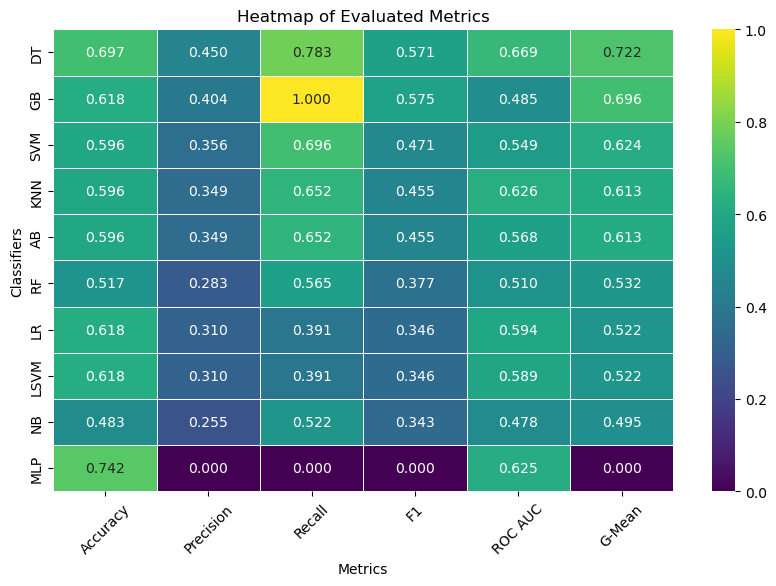

In [7]:
# Defining the names of the evaluation metrics
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'G-Mean']

# Selecting the metrics for the heatmap and configuring the index
heatmap_df = results_df[metric_names].set_index(results_df['classifier'])

# Sorting the DataFrame by G-Mean value
heatmap_df = heatmap_df.sort_values(by='G-Mean', ascending=False)

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, cmap='viridis', annot=True, fmt=".3f", linewidths=.5)
plt.title('Heatmap of Evaluated Metrics')
plt.xlabel('Metrics')
plt.ylabel('Classifiers')
plt.xticks(rotation=45)
plt.savefig('..\\results\\heatmap.jpeg')
plt.show()


Polar plot

Dropdown(description='Modelo 1', options=('GB', 'LR', 'MLP', 'SVM', 'LSVM', 'DT', 'RF', 'NB', 'AB', 'KNN'), va…

Dropdown(description='Modelo 2', index=1, options=('GB', 'LR', 'MLP', 'SVM', 'LSVM', 'DT', 'RF', 'NB', 'AB', '…

Dropdown(description='Modelo 3', index=2, options=('GB', 'LR', 'MLP', 'SVM', 'LSVM', 'DT', 'RF', 'NB', 'AB', '…

Dropdown(description='Modelo 4', index=3, options=('GB', 'LR', 'MLP', 'SVM', 'LSVM', 'DT', 'RF', 'NB', 'AB', '…

Button(description='Gerar Gráfico', style=ButtonStyle())

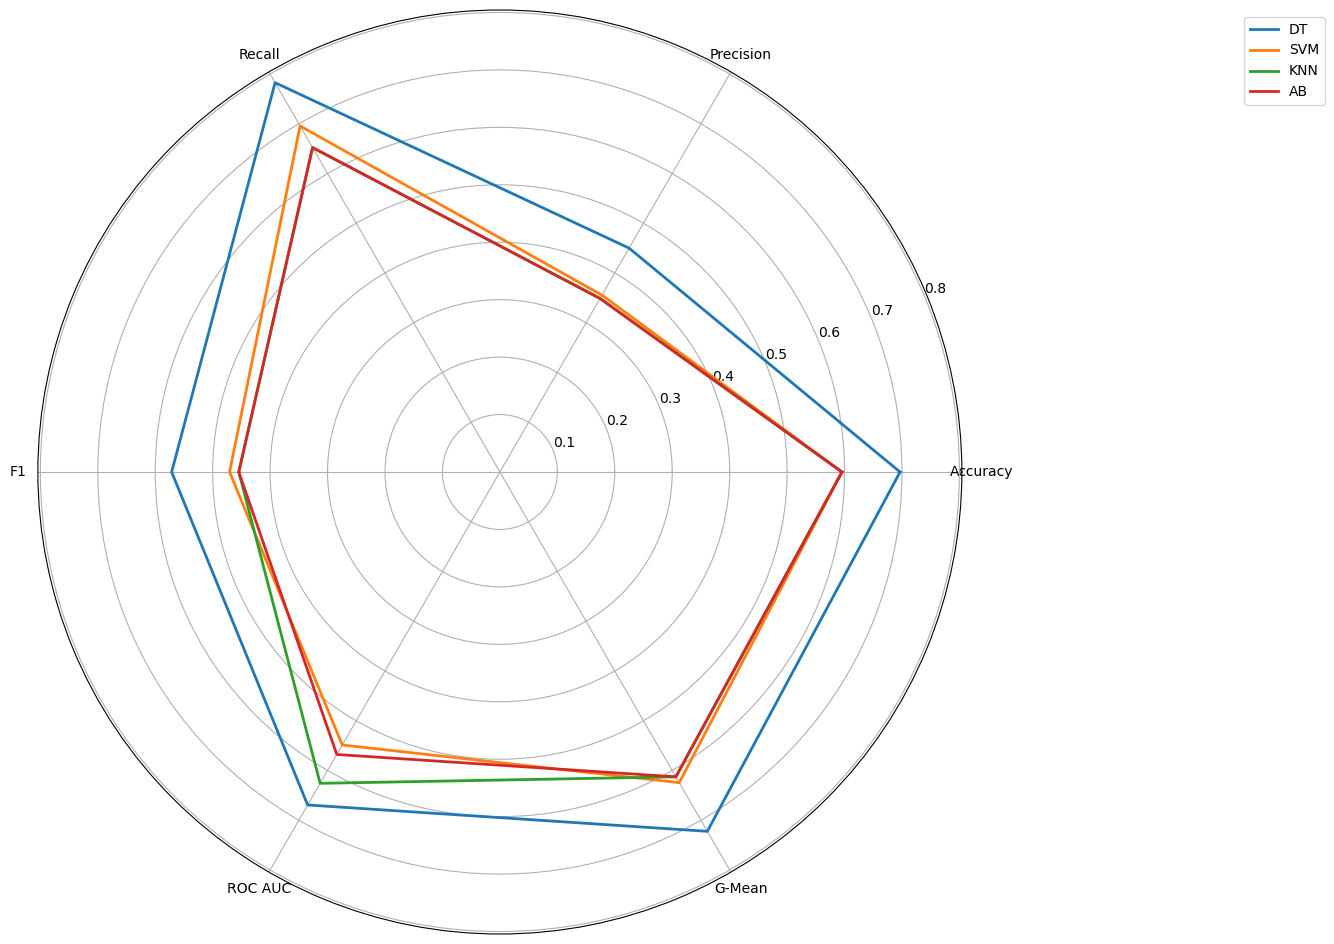

Gráfico salvo em: ..\results\polar_plot.jpeg


In [7]:
# Define the available classifiers
available_models = ['GB', 'LR', 'MLP', 'SVM', 'LSVM', 'DT', 'RF', 'NB', 'AB', 'KNN']

# Model selection widgets
model_selector_1 = widgets.Dropdown(options=available_models, description='Modelo 1', value=available_models[0])
model_selector_2 = widgets.Dropdown(options=available_models, description='Modelo 2', value=available_models[1])
model_selector_3 = widgets.Dropdown(options=available_models, description='Modelo 3', value=available_models[2])
model_selector_4 = widgets.Dropdown(options=available_models, description='Modelo 4', value=available_models[3])

# Display the widgets to the user
display(model_selector_1, model_selector_2, model_selector_3, model_selector_4)
def plot_selected_models(results_df):
    # Get the selected models from the dropdowns
    selected_models = [model_selector_1.value, model_selector_2.value, model_selector_3.value, model_selector_4.value]

    # Check for duplicates in the selected templates
    if len(selected_models) != len(set(selected_models)):
        print("Por favor, selecione modelos diferentes em cada widget.")
        return

    # Filter the results for the selected models
    results_df_filtered = results_df[results_df['classifier'].isin(selected_models)]

    # Creating the figure for the polar graph
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': 'polar'})

    # Iterate over each row of the filtered DataFrame and plot the metrics on the polar graph
    for i, row in results_df_filtered.iterrows():
        # Take the metrics in order
        metrics = [row['Accuracy'], row['Precision'], row['Recall'], row['F1'], row['ROC AUC'], row['G-Mean']]
        
        # Connect the first value to the last to close the graph
        metrics.append(metrics[0])
        
        # Define the angles and plot on the polar graph
        angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=True)
        ax.plot(angles, metrics, label=row['classifier'], linewidth=2)

    # Configuring the axis labels
    ax.set_xticks(np.linspace(0, 2*np.pi, 6, endpoint=False))
    ax.set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'G-Mean'])

    # Adicionar uma legenda fora do gráfico
    ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1))

    # Define the colors of the graph
    ax.set_prop_cycle(color=plt.cm.viridis(np.linspace(0, 1, len(results_df_filtered))))

    # Display the graph
    plt.show()

    # Save the graph
    save_path = '..\\results\\polar_plot.jpeg'
    fig.savefig(save_path, bbox_inches='tight')
    print(f"Gráfico salvo em: {save_path}")
    
# Create button to plot the graph
plot_button = widgets.Button(description="Gerar Gráfico")

# Function to be executed when the button is clicked
def on_plot_button_clicked(b):
    plot_selected_models(results_df)
plot_button.on_click(on_plot_button_clicked)
display(plot_button)


Bar graph comparation plot

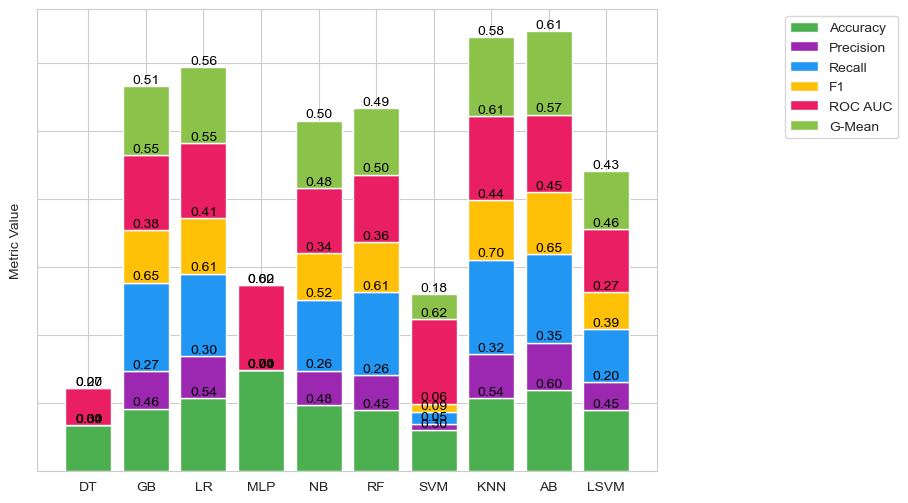

Gráfico salvo em: ../results/bar_plot_all_models.png


In [6]:
# Configure the seaborn style
sns.set_style("whitegrid")

# Create the figure
fig, ax = plt.subplots(figsize=(8, 6))

# Create the bars for each metric
bars = ax.bar(range(len(results_df)), results_df['Accuracy'], label='Accuracy', color='#4CAF50')  # Green
for i, (bar, value) in enumerate(zip(bars, results_df['Accuracy'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{value:.2f}", ha='center', va='bottom', color='black')

bars = ax.bar(range(len(results_df)), results_df['Precision'], bottom=results_df['Accuracy'], label='Precision', color='#9C27B0')  # Purple
for i, (bar, value) in enumerate(zip(bars, results_df['Precision'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + results_df['Accuracy'].iloc[i], f"{value:.2f}", ha='center', va='bottom', color='black')

bars = ax.bar(range(len(results_df)), results_df['Recall'], bottom=results_df['Accuracy'] + results_df['Precision'], label='Recall', color='#2196F3')  # Blue
for i, (bar, value) in enumerate(zip(bars, results_df['Recall'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (results_df['Accuracy'] + results_df['Precision']).iloc[i], f"{value:.2f}", ha='center', va='bottom', color='black')

bars = ax.bar(range(len(results_df)), results_df['F1'], bottom=results_df['Accuracy'] + results_df['Precision'] + results_df['Recall'], label='F1', color='#FFC107')  # Yellow
for i, (bar, value) in enumerate(zip(bars, results_df['F1'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (results_df['Accuracy'] + results_df['Precision'] + results_df['Recall']).iloc[i], f"{value:.2f}", ha='center', va='bottom', color='black')

bars = ax.bar(range(len(results_df)), results_df['ROC AUC'], bottom=results_df['Accuracy'] + results_df['Precision'] + results_df['Recall'] + results_df['F1'], label='ROC AUC', color='#E91E63')  # Pink
for i, (bar, value) in enumerate(zip(bars, results_df['ROC AUC'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (results_df['Accuracy'] + results_df['Precision'] + results_df['Recall'] + results_df['F1']).iloc[i], f"{value:.2f}", ha='center', va='bottom', color='black')

bars = ax.bar(range(len(results_df)), results_df['G-Mean'], bottom=results_df['Accuracy'] + results_df['Precision'] + results_df['Recall'] + results_df['F1'] + results_df['ROC AUC'], label='G-Mean', color='#8BC34A')  # Light Green
for i, (bar, value) in enumerate(zip(bars, results_df['G-Mean'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (results_df['Accuracy'] + results_df['Precision'] + results_df['Recall'] + results_df['F1'] + results_df['ROC AUC']).iloc[i], f"{value:.2f}", ha='center', va='bottom', color='black')

# Chart settings
ax.set_xticks(range(len(results_df)))
ax.set_yticklabels([])
ax.set_xticklabels(results_df['classifier'])
ax.set_ylabel('Metric Value')
ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1))

# Display the graph
plt.show()

# Save the graphs
save_path = '../results/bar_plot_all_models.png'
fig.savefig(save_path, bbox_inches='tight')
print(f"Gráfico salvo em: {save_path}")


Learning Curves

In [17]:
def plot_learning_curve(X, y, classifiers, balancing_method, train_sizes=np.linspace(0.1, 1.0, 10)):
    results_dir = '..\\results\\'
    
    # Make sure the results directory exists
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)

    for name, clf in classifiers.items():
        # Defining the pipeline
        pipeline = Pipeline([
            ('balancing', balancing_method),  # Balanceamento usando método selecionado
            ('classifier', clf)  # Classificador
        ])
        
        # Calculating learning curves
        train_sizes_abs, train_scores, test_scores = learning_curve(
            pipeline, X, y, train_sizes=train_sizes, cv=loo, scoring='accuracy', n_jobs=-1
        )

        # Calculating the averages and standard deviations of training and test scores
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        # Plotting the learning curves
        plt.figure()
        plt.title(f'Curva de Aprendizado - {name}')
        plt.xlabel("Amostras de Treinamento")
        plt.ylabel("Acurácia")

        plt.plot(train_sizes_abs, train_scores_mean, 'o-', color="r", label="Pontuação de Treinamento")
        plt.plot(train_sizes_abs, test_scores_mean, 'o-', color="g", label="Pontuação de Teste")

        # Filling in error areas
        plt.fill_between(train_sizes_abs, 
                         train_scores_mean - train_scores_std, 
                         train_scores_mean + train_scores_std, 
                         alpha=0.1, color="r")
        plt.fill_between(train_sizes_abs, 
                         test_scores_mean - test_scores_std, 
                         test_scores_mean + test_scores_std, 
                         alpha=0.1, color="g")

        plt.legend(loc="best")
        plt.grid(True)
        
        # Saving the plot
        plot_filename = os.path.join(results_dir, f'curva_aprendizado_{name}.png')
        plt.savefig(plot_filename)
        plt.close()  

plot_learning_curve(X, y, classifiers, balancing_method)


c:\Users\lmbbu\anaconda3\envs\ML-2024python3_11__20241004\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
267 fits failed out of a total of 890.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
89 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\lmbbu\anaconda3\envs\ML-2024python3_11__20241004\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\lmbbu\anaconda3\envs\ML-2024python3_11__20241004\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\l

In [50]:
print(balancing_method)

RandomUnderSampler(random_state=42)


Confusion matrix with LOOCV and balancing method to prediction, but just the original samples in the plot

Método de balanceamento desconhecido: SMOTENC
Predicted labels distribution for DT: [89]


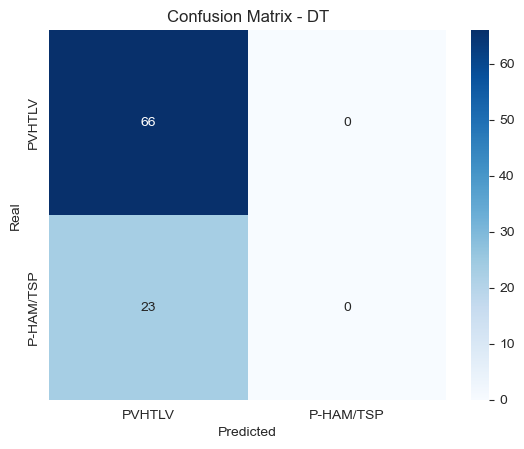

Método de balanceamento desconhecido: SMOTENC
Predicted labels distribution for GB: [65 24]


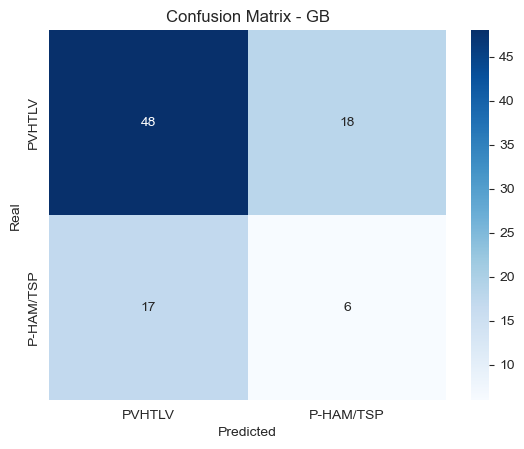

Método de balanceamento desconhecido: SMOTENC
Predicted labels distribution for LR: [56 33]


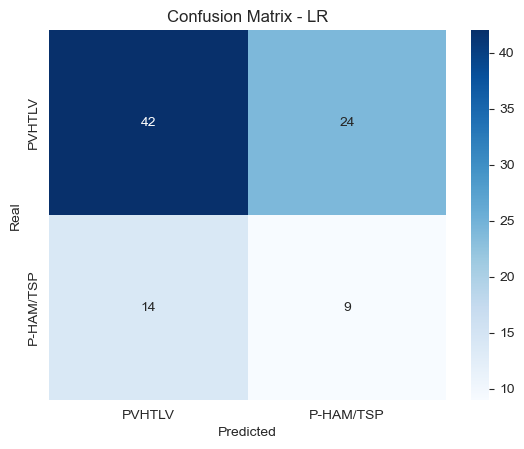

Método de balanceamento desconhecido: SMOTENC
Predicted labels distribution for MLP: [89]


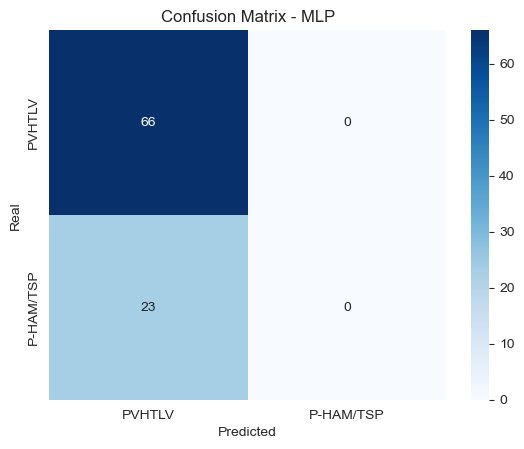

Método de balanceamento desconhecido: SMOTENC
Predicted labels distribution for NB: [58 31]


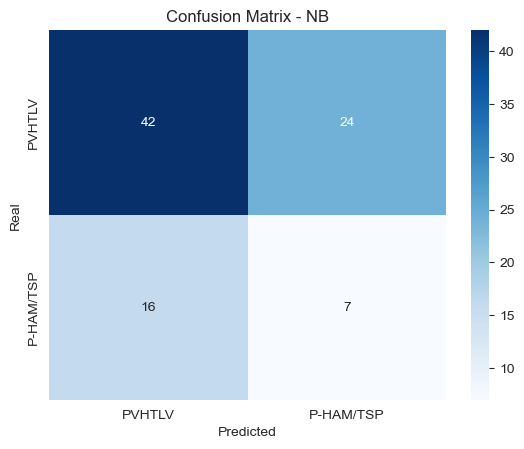

Método de balanceamento desconhecido: SMOTENC
Predicted labels distribution for RF: [68 21]


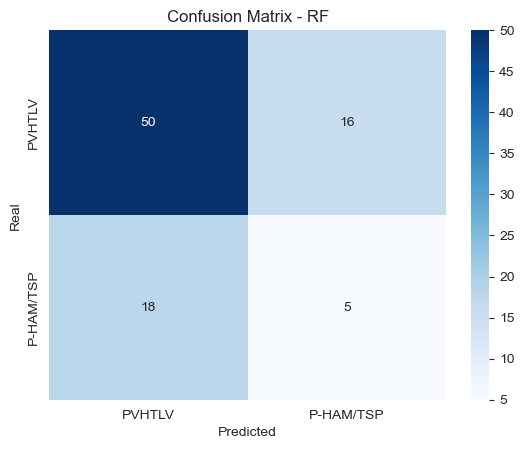

Método de balanceamento desconhecido: SMOTENC
Predicted labels distribution for SVM: [89]


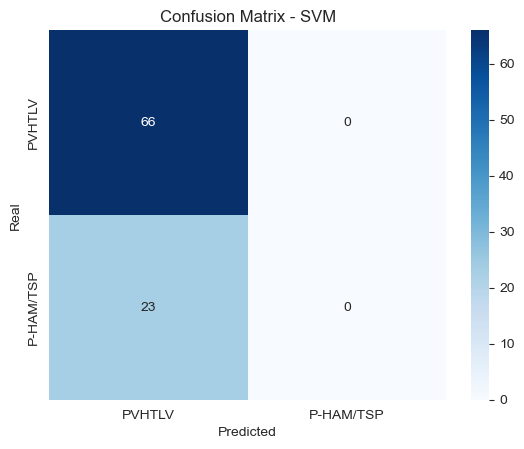

Método de balanceamento desconhecido: SMOTENC
Predicted labels distribution for KNN: [52 37]


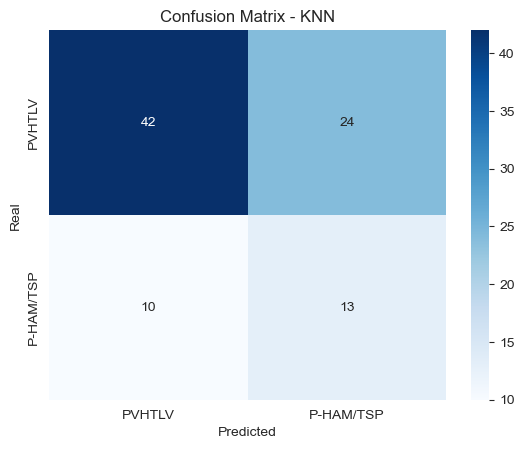

Método de balanceamento desconhecido: SMOTENC


c:\Users\lmbbu\anaconda3\envs\ML-2024python3_11__20241004\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\lmbbu\anaconda3\envs\ML-2024python3_11__20241004\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\lmbbu\anaconda3\envs\ML-2024python3_11__20241004\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\lmbbu\anaconda3\envs\ML-2024python3_11__20241004\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the 

Predicted labels distribution for AB: [69 20]


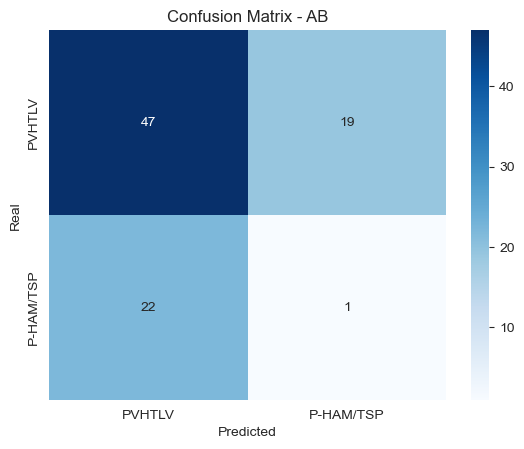

Método de balanceamento desconhecido: SMOTENC


c:\Users\lmbbu\anaconda3\envs\ML-2024python3_11__20241004\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\lmbbu\anaconda3\envs\ML-2024python3_11__20241004\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\lmbbu\anaconda3\envs\ML-2024python3_11__20241004\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\lmbbu\anaconda3\envs\ML-2024python3_11__20241004\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\lmbbu\anaconda3\envs\ML-2024python3_11__20241

Predicted labels distribution for LSVM: [59 30]


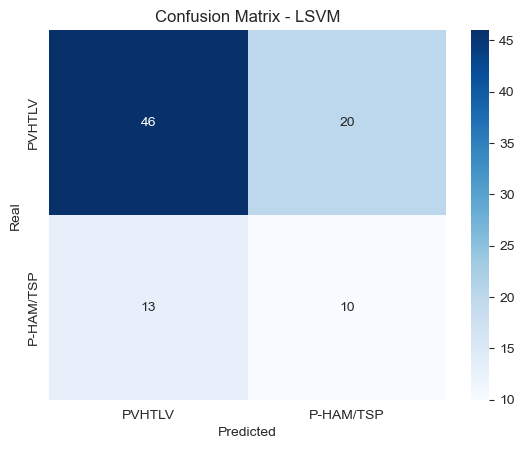

In [18]:
def get_balancing_method():
    global balancing_method_selected
    if balancing_method_selected == 'Random Over Sampler':
        return RandomOverSampler(random_state=42)
    elif balancing_method_selected == 'ADASYN':
        return ADASYN(random_state=42)
    elif balancing_method_selected == 'Random Under Sampler':
        return RandomUnderSampler(random_state=42)
    elif balancing_method_selected == 'Tomek Links':
        return TomekLinks()
    else:
        print(f"Método de balanceamento desconhecido: {balancing_method_selected}")
        return None

def plot_confusion_matrix(model_name):
    # Select the model
    model = classifiers[model_name]

    # Get the balancing method
    balancing_method = get_balancing_method()

    # Define the pipeline using the balancing method and the classifier
    pipeline = Pipeline([
        ('balancing', balancing_method),  # Balanceamento usando método selecionado
        ('classifier', model)  # Classificador
    ])
    
    # Making predictions using cross_val_predict with the pipeline
    y_preds = cross_val_predict(pipeline, X, y, cv=loo)

    # Calculate the confusion matrix
    cm = confusion_matrix(y, y_preds) 
    
    # Print the predicted labels distribution for debugging
    print(f"Predicted labels distribution for {model_name}: {np.bincount(y_preds)}")
    
    # Define custom labels
    labels = ['PVHTLV', 'P-HAM/TSP']

    # Plot the heat map
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Real')
    plt.title(f'Confusion Matrix - {model_name}')
    
    # Save the picture
    plt.savefig(f'../results/{model_name}_confusion_matrix.jpeg')
    plt.show()

# Iterating over each model in classifiers
for model_name in classifiers:
    plot_confusion_matrix(model_name)


Confunsion matrix with the balancing method in the plot

Predicted labels distribution for DT: [148]


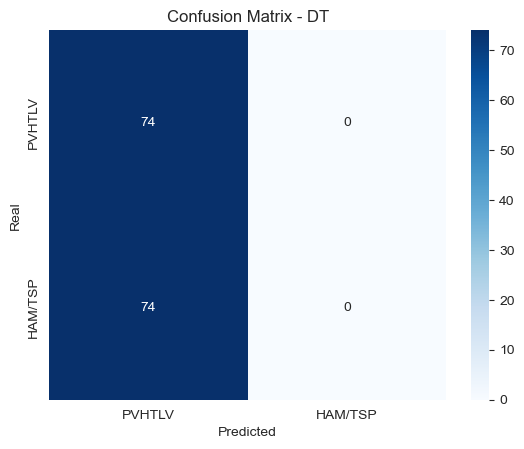

Predicted labels distribution for GB: [73 75]


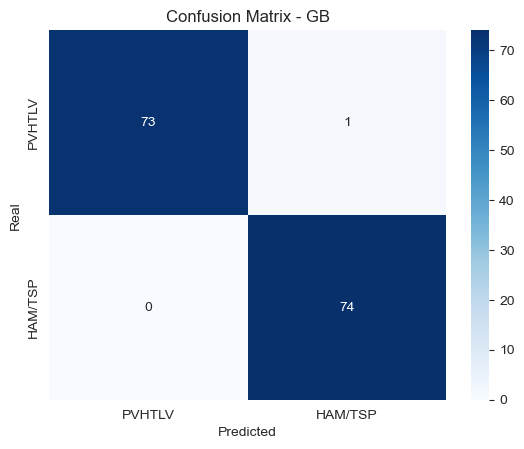

Predicted labels distribution for LR: [95 53]


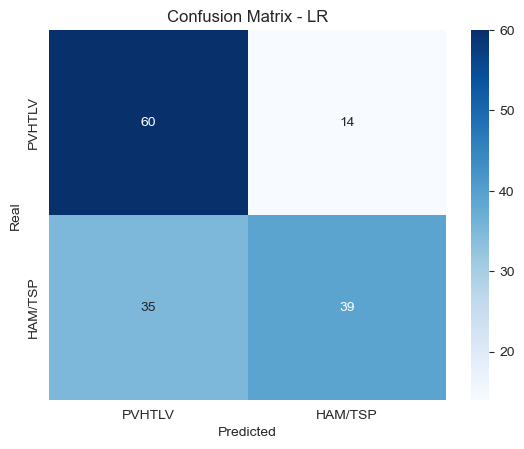

Predicted labels distribution for MLP: [73 75]


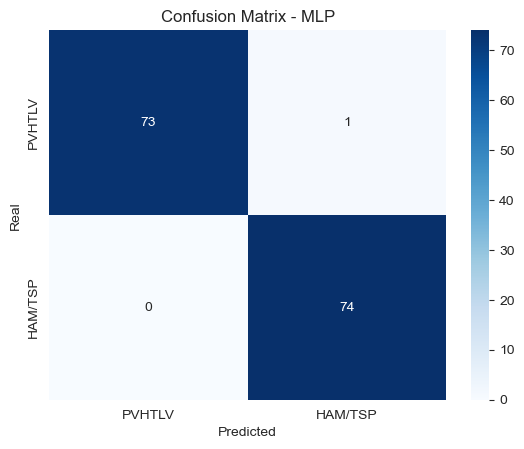

Predicted labels distribution for NB: [94 54]


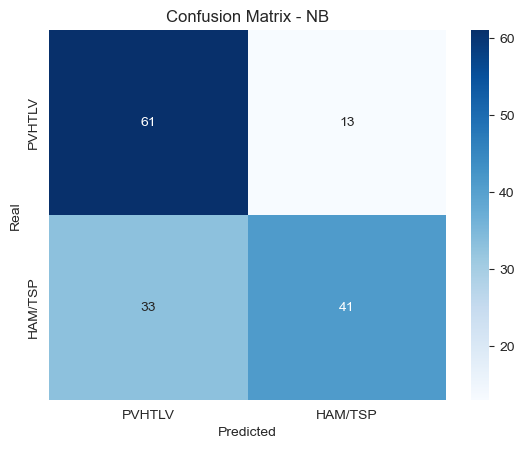

Predicted labels distribution for RF: [68 80]


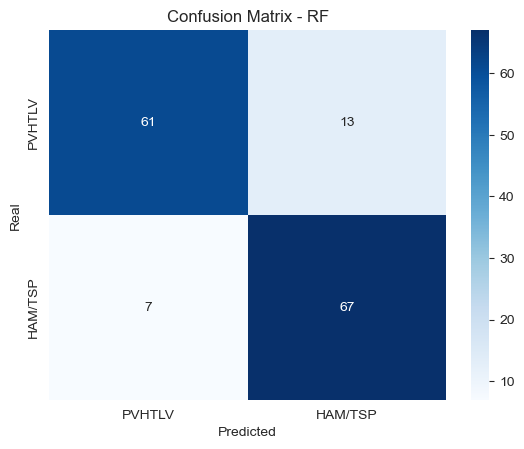

Predicted labels distribution for SVM: [73 75]


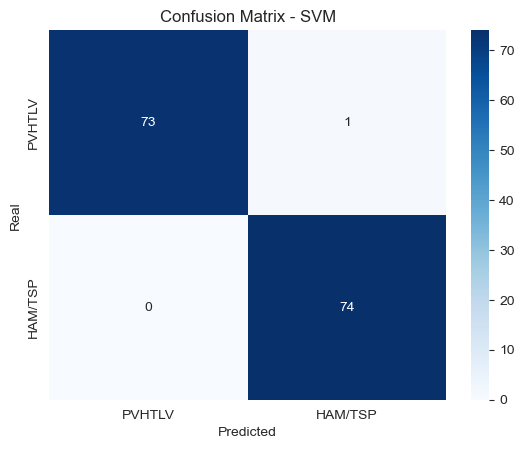

Predicted labels distribution for KNN: [73 75]


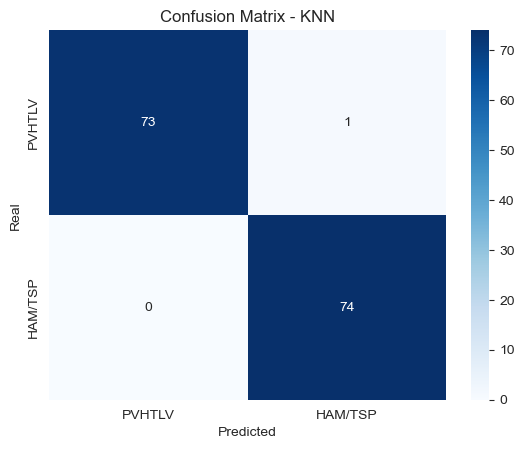

c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Predicted labels distribution for AB: [73 75]


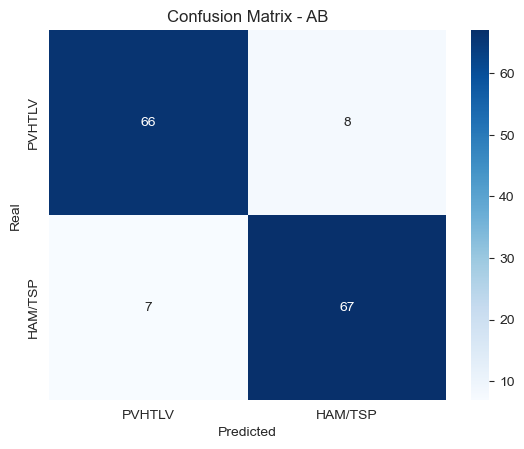

c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Predicted labels distribution for LSVM: [92 56]


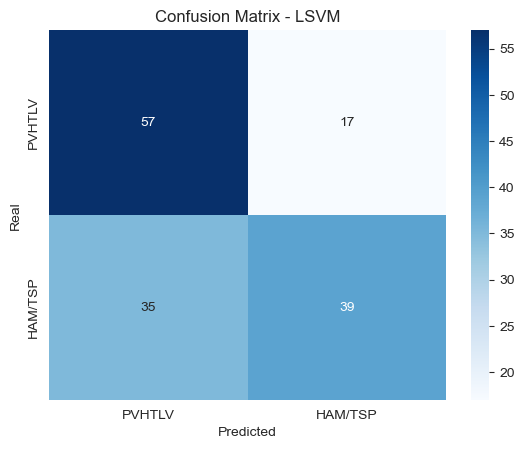

In [43]:
def plot_confusion_matrix(model_name):
    # Select the model
    model = classifiers[model_name]

    # Get the balancing method
    balancing_method = get_balancing_method()

    # Define the pipeline using the balancing method and the classifier
    pipeline = Pipeline([
        ('balancing', balancing_method),  # Balanceamento usando método selecionado
        ('classifier', model)  # Classificador
    ])
    
    # Fit the pipeline to the data
    pipeline.fit(X, y)
    
    # Resample the data using the balancing method
    X_res, y_res = balancing_method.fit_resample(X, y)
    
    # Make predictions on the resampled data
    y_preds = pipeline.predict(X_res)
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y_res, y_preds) 
    
    # Print the predicted labels distribution for debugging
    print(f"Predicted labels distribution for {model_name}: {np.bincount(y_preds)}")
    
    # Define custom labels
    labels = ['PVHTLV', 'HAM/TSP']

    # Plot the heat map
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Real')
    plt.title(f'Confusion Matrix - {model_name}')
    
    # Save the picture
    #plt.savefig(f'../results/{model_name}_confusion_matrix.jpeg')
    plt.show()
# Iterating over each model in classifiers
for model_name in classifiers:
    plot_confusion_matrix(model_name)

In [8]:
import numpy as np
import pandas as pd
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Diretório onde as predições foram salvas
prediction_dir = '..\\predictions\\'

# Lista dos classificadores cujas predições foram salvas
classifiers = ['DT', 'GB', 'LR', 'MLP', 'NB', 'RF', 'SVM', 'KNN', 'AB', 'LSVM']

# Carregar as predições salvas
def load_predictions():
    predictions = []
    for clf_name in classifiers:
        pred_path = os.path.join(prediction_dir, f'{clf_name}_predictions.csv')
        if os.path.exists(pred_path):
            df = pd.read_csv(pred_path)
            predictions.append(df[f'{clf_name}_Predictions'].values)
        else:
            print(f'Predições para o modelo {clf_name} não encontradas.')
    return np.array(predictions).T  # Transpor para obter as predições de cada modelo como colunas

# Carregar as predições
X_meta = load_predictions()

# Labels reais (pode ser a partir de um dataset ou de uma das predições salvas)
y = pd.read_csv(os.path.join(prediction_dir, f'{classifiers[0]}_predictions.csv'))['True Labels'].values

# Inicializando os classificadores de base (com os modelos que você treinou anteriormente)
clf1 = load(os.path.join(model_dir, 'best_RF_model.joblib'))
clf2 = load(os.path.join(model_dir, 'best_KNN_model.joblib'))
clf3 = load(os.path.join(model_dir, 'best_LR_model.joblib'))

# Definir o meta-modelo (neste caso, Logistic Regression, mas pode ser qualquer outro)
meta_clf = LogisticRegression()

# Criar o StackingClassifier
stacked_clf = StackingClassifier(classifiers=[clf1, clf2, clf3], meta_classifier=meta_clf)

# Avaliar o modelo com cross-validation
scores = cross_val_score(stacked_clf, X_meta, y, cv=5, scoring='accuracy')

print(f'Accuracies do Stacking: {scores}')
print(f'Acurácia média: {scores.mean()}')

# Treinar o meta-modelo (opcional, se você quiser treinar e salvar)
stacked_clf.fit(X_meta, y)


c:\Users\lmbbu\anaconda3\envs\ML-2024python3_11__20241004\Lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\lmbbu\anaconda3\envs\ML-2024python3_11__20241004\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\lmbbu\anaconda3\envs\ML-2024python3_11__20241004\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "c:\Users\lmbbu\anaconda3\envs\ML-2024python3_11__20241004\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lmbbu\anaconda3\envs\ML-2024python3_11__20241004\Lib\site-packages\sklearn\utils\_response.py", line 198, in _get_re

Accuracies do Stacking: [nan nan nan nan nan]
Acurácia média: nan


c:\Users\lmbbu\anaconda3\envs\ML-2024python3_11__20241004\Lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\lmbbu\anaconda3\envs\ML-2024python3_11__20241004\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\lmbbu\anaconda3\envs\ML-2024python3_11__20241004\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "c:\Users\lmbbu\anaconda3\envs\ML-2024python3_11__20241004\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lmbbu\anaconda3\envs\ML-2024python3_11__20241004\Lib\site-packages\sklearn\utils\_response.py", line 198, in _get_re

StackingClassifier(classifiers=[Pipeline(steps=[('normalization',
                                                 MinMaxScaler()),
                                                ('balancing',
                                                 SMOTENC(categorical_features=[0,
                                                                               2,
                                                                               3,
                                                                               4,
                                                                               5,
                                                                               6],
                                                         random_state=42)),
                                                ('classifier',
                                                 RandomForestClassifier(class_weight='balanced_subsample',
                                                                        criterion='entropy',
                                                                        max_depth=9,
                                                                        max_samples=0.667028859699749,
                                                                        min_samples_leaf=3,
                                                                        min_samples_split=4,
                                                                        n_estimators=50,
                                                                        random_...
                                                 KNeighborsClassifier(algorithm='ball_tree',
                                                                      leaf_size=48,
                                                                      n_neighbors=3,
                                                                      p=1))]),
                                Pipeline(steps=[('normalization',
                                                 MinMaxScaler()),
                                                ('balancing',
                                                 SMOTENC(categorical_features=[0,
                                                                               2,
                                                                               3,
                                                                               4,
                                                                               5,
                                                                               6],
                                                         random_state=42)),
                                                ('classifier',
                                                 LogisticRegression(C=72.73082081096716,
                                                                    max_iter=746,
                                                                    random_state=42,
                                                                    solver='saga',
                                                                    tol=0.0008777151239184556))])],
                   meta_classifier=LogisticRegression())